In [1]:
import numpy as np
import pandas as pd
import healpy as hp
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib import pyplot as plt
from DS_Planck_Unet import east_val, west_val, train_pix
from DS_healpix_fragmentation import pix2radec, radec2pix
from DS_data_transformation import normalize
from DS_data_transformation import get_cat_name
from astropy.io import fits
from DS_data_transformation import fits2df

In [43]:
df = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv')
psz2 = pd.read_csv('/home/rt2122/Data/original_catalogs/csv/PSZ2.csv')

In [44]:
def make_histogram(ax, tp, fp, n_bins, label1='Yes matches', label2='No matches'):
    ax.hist(tp, n_bins, color='r', log=True, histtype='step', label=label1)
    ax.hist(fp, n_bins, color='b', log=True, histtype='step', label=label2)
    ax.legend()

In [45]:
df_sc = SkyCoord(ra=np.array(df['RA'])*u.degree, dec=np.array(df['DEC'])*u.degree, frame='icrs')
psz2_sc = SkyCoord(ra=np.array(psz2['RA'])*u.degree, dec=np.array(psz2['DEC'])*u.degree, frame='icrs')

In [46]:
idx, d2d, _ = df_sc.match_to_catalog_sky(psz2_sc)

In [47]:
red = d2d.degree < (400/3600)
#psz2 = psz2.iloc[idx[np.logical_not(red)]]
psz2_sc = SkyCoord(ra=np.array(psz2['RA'][np.logical_not(red)])*u.degree, dec=np.array(psz2['DEC'][np.logical_not(red)])*u.degree, frame='icrs')
idx, d2d, _ = df_sc.match_to_catalog_sky(psz2_sc)
violet = d2d.degree < (400/3600)
blue = np.logical_and(d2d.degree >= 400/3600, d2d.degree <1500/3600)

IndexError: Boolean index has wrong length: 23352 instead of 1653

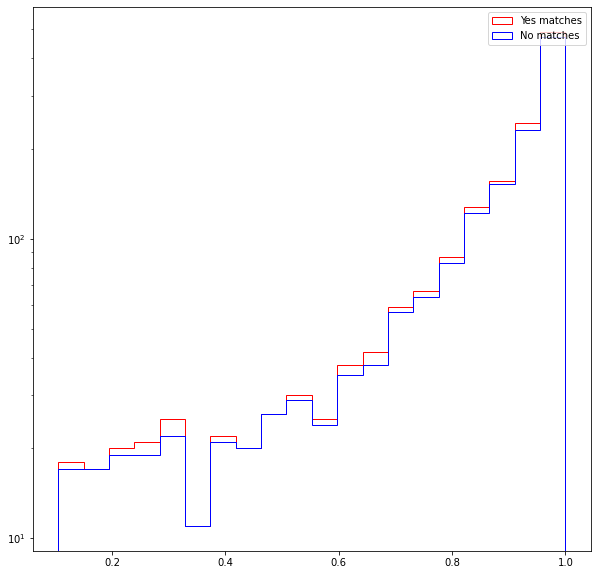

In [48]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))
make_histogram(ax, df['max_pred'][red], df['max_pred'][violet], n_bins=20)

In [49]:
np.count_nonzero(red)

1545

In [50]:
len(psz2)

1653

In [2]:
pz = pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv')

In [5]:
cur = pz[np.abs(pz['M500'] - 4.79848) < 0.001]
cur

,Name,RA,DEC,z,M500,MCXC,RedMAPPer
343,PSZ2 G104.98-54.79,2.558396,6.63386,0.291234,4.79848,,RMJ001015.3+064045.0


In [6]:
ra, dec = 2.558396, 6.63386

In [7]:
pzsc = SkyCoord(ra=np.array(pz['RA'])*u.degree, dec=np.array(pz['DEC'])*u.degree, frame='icrs')
sc=SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
angle = sc.separation(pzsc).degree

In [12]:
pz[angle < 30/60]

,Name,RA,DEC,z,M500,MCXC,RedMAPPer
341,PSZ2 G104.71-54.54,2.339505,6.829252,0.244062,4.89872,,RMJ000920.7+064923.1
343,PSZ2 G104.98-54.79,2.558396,6.633860,0.291234,4.79848,,RMJ001015.3+064045.0


In [6]:
big_pix = np.arange(48)
ra, dec = pix2radec(east_val + west_val, nside=2) 
sc = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
sc.galactic.l.degree

array([112.5, 112.5, 247.5, 247.5])

In [11]:
ra, dec = pix2radec(big_pix, nside=2)
sc = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
east = sc.galactic.l.degree <= 180
big_pix[east]

array([ 0,  1,  2,  3,  4,  5,  6,  7, 16, 17, 20, 21, 22, 23, 24, 26, 27,
       32, 33, 34, 35, 36, 37, 38, 39])

In [14]:
len(big_pix[east])
big_pix[np.logical_not(east)]

array([ 8,  9, 10, 11, 12, 13, 14, 15, 18, 19, 25, 28, 29, 30, 31, 40, 41,
       42, 43, 44, 45, 46, 47])

In [ ]:
east = [0,  1,  2,  3,  4,  5,  6,  7, 16, 17, 20, 21, 22, 23, 24, 26, 27,
       32, 33, 34, 35, 36, 37, 38, 39]
west = [ 8,  9, 10, 11, 12, 13, 14, 15, 18, 19, 25, 28, 29, 30, 31, 40, 41,
       42, 43, 44, 45, 46, 47]

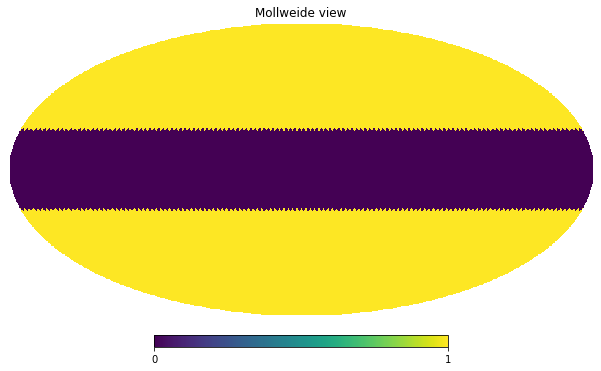

In [5]:
nside=2**5
a = np.zeros(hp.nside2npix(nside))
ra, dec = pix2radec(np.arange(hp.nside2npix(nside)), nside=nside) 
sc = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
a[np.abs(sc.galactic.b.degree) >= 20] = 1
hp.mollview(a, nest=True)

In [6]:
def cut_cat(df, big_pix):
    
    pix2 = radec2pix(df['RA'], df['DEC'], 2)
    df = df[np.in1d(pix2, big_pix)]
    df.index = np.arange(len(df))
    
    return df

In [8]:
planck_z = pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv')

In [11]:
len(cut_cat(planck_z.copy(), train_pix))

922

In [12]:
len(cut_cat(planck_z.copy(), [9, 41]))

82

In [13]:
len(cut_cat(planck_z.copy(), [9]))

29

In [14]:
len(cut_cat(planck_z.copy(), [41]))

53

In [16]:
len(cut_cat(planck_z.copy(), [38, 6]))

90

In [17]:
len(cut_cat(planck_z.copy(), [38]))

50

In [18]:
len(cut_cat(planck_z.copy(), [6]))

40

In [24]:
y_map = np.load('/home/rt2122/Data/Planck/normalized/y/nilc.npy')


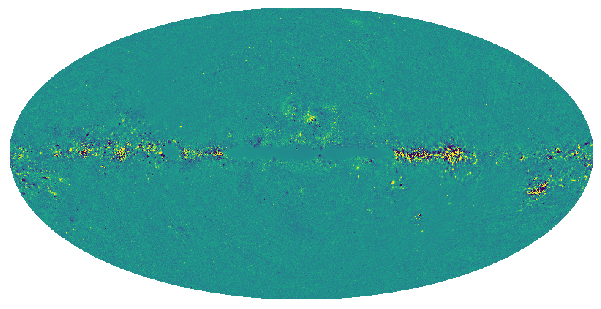

In [28]:
hp.mollview(np.clip(y_map, -4, 4), nest=True, title='', cbar=False)

In [23]:
y_map.min(), y_map.max()

(0.0, 1.0)

In [3]:
df = pd.read_csv('/home/rt2122/Data/clusters/acts/all_found.csv')

In [6]:
df['pix2'] = radec2pix(df['RA'], df['DEC'], 2)

In [22]:
set(df['catalog'])

{'actwp', 'mcxcwp', 'planck_no_z'}

In [16]:
actwp = df[df['catalog'] == '']

In [17]:
np.count_nonzero(np.in1d(actwp['pix2'], train_pix))

197

In [18]:
np.count_nonzero(np.in1d(actwp['pix2'], [9]))

5

In [19]:
np.count_nonzero(np.in1d(actwp['pix2'], [41]))

7

In [20]:
np.count_nonzero(np.in1d(actwp['pix2'], [38]))

6

In [21]:
np.count_nonzero(np.in1d(actwp['pix2'], [6]))

4

In [56]:
files = ['/home/rt2122/Data/original_catalogs/csv/PSZ2.csv', '/home/rt2122/Data/clusters/planck_z.csv', 
         '/home/rt2122/Data/clusters/inter_cats/act_inter.csv', '/home/rt2122/Data/original_catalogs/csv/ACT.csv', 
         '/home/rt2122/Data/clusters/inter_cats/mcxc_inter.csv', '/home/rt2122/Data/original_catalogs/csv/MCXC.csv',
         '/home/rt2122/Data/clusters/inter_cats/abell_inter.csv', '/home/rt2122/Data/original_catalogs/csv/Abell.csv', 
         #'/home/rt2122/Data/clusters/inter_cats/rm_inter.csv', '/home/rt2122/Data/original_catalogs/csv/RM.csv'
         '/home/rt2122/Data/clusters/inter_cats/rm_old_inter.csv', '/home/rt2122/Data/original_catalogs/csv/other/RM_5.2.csv'
        ]

In [57]:
index = ['Objects', 'Training sample', 'Validation sample', '9', '41', 'Test sample', '38', '6']
dicts = [{} for i in range(len(index))]
func = [lambda df: len(df), 
        lambda df: np.count_nonzero(np.in1d(df['pix2'], train_pix)),
        lambda df: np.count_nonzero(np.in1d(df['pix2'], west_val)),
        lambda df: np.count_nonzero(np.in1d(df['pix2'], [9])),
        lambda df: np.count_nonzero(np.in1d(df['pix2'], [41])),
        lambda df: np.count_nonzero(np.in1d(df['pix2'], east_val)),
        lambda df: np.count_nonzero(np.in1d(df['pix2'], [38])),
        lambda df: np.count_nonzero(np.in1d(df['pix2'], [6]))
       ]

for file in files:
    name = get_cat_name(file) 
    df = pd.read_csv(file)
    df['pix2'] = radec2pix(df['RA'], df['DEC'], 2)
    for i in range(len(index)):
        dicts[i][name] = func[i](df)

res_df = pd.DataFrame(dicts, index=index)
res_df

,PSZ2,planck_z,act_inter,ACT,mcxc_inter,MCXC,abell_inter,Abell,rm_old_inter,RM_5.2
Objects,1653,1094,3814,4195,1115,1743,3241,4076,22890,25325
Training sample,1435,922,3273,3593,970,1507,2804,3510,19591,21721
Validation sample,100,82,425,471,62,106,230,297,743,839
9,42,29,133,143,24,38,90,118,743,839
41,58,53,292,328,38,68,140,179,0,0
Test sample,118,90,116,131,83,130,207,269,2556,2765
38,60,50,116,131,33,60,92,120,2064,2233
6,58,40,0,0,50,70,115,149,492,532


In [8]:
west_val

[9, 41]

In [12]:
with fits.open('/home/rt2122/Data/original_catalogs/redmapper_dr8_public_v5.2_catalog.fits') as hdul:
    print(hdul[1].data.shape)

(25325,)


In [26]:
def dif_for_cats(main_cat, minus_cat, rad=5/60):
    print('First cat: {}; Second cat:{}'.format(len(main_cat), len(minus_cat)))
    main_sc = SkyCoord(ra=np.array(main_cat['RA']) * u.degree, dec=np.array(main_cat['DEC']) * u.degree, frame='icrs')
    minus_sc = SkyCoord(ra=np.array(minus_cat['RA']) * u.degree, dec=np.array(minus_cat['DEC']) * u.degree, frame='icrs')
    
    _, d2d, _ = main_sc.match_to_catalog_sky(minus_sc)
    matched = d2d.degree <= rad
    
    print('Intersection: {}'.format(np.count_nonzero(matched)))
    
    main_cat = main_cat[np.logical_not(matched)]
    main_cat.index = np.arange(len(main_cat))
    print('Res cat: {}'.format(len(main_cat)))
    return main_cat

In [2]:
PSZ2 = pd.read_csv('/home/rt2122/Data/original_catalogs/csv/PSZ2.csv')
ACT = pd.read_csv('/home/rt2122/Data/original_catalogs/csv/ACT.csv')
planck_z = pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv')
MCXC = pd.read_csv('/home/rt2122/Data/original_catalogs/csv/MCXC.csv')
RM = pd.read_csv('/home/rt2122/Data/original_catalogs/csv/RM.csv')
Abell = pd.read_csv('/home/rt2122/Data/original_catalogs/csv/Abell.csv')

In [27]:
actwp = dif_for_cats(ACT, PSZ2)
actwp.to_csv('/home/rt2122/Data/clusters/inter_cats/act_inter.csv', index=False)
print(len(ACT))

First cat: 4195; Second cat:1653
Intersection: 381
Res cat: 3814
4195


In [29]:
mcxcwp = dif_for_cats(MCXC, pd.concat([PSZ2, ACT]))
mcxcwp.to_csv('/home/rt2122/Data/clusters/inter_cats/mcxc_inter.csv', index=False)

First cat: 1743; Second cat:5848
Intersection: 628
Res cat: 1115


In [30]:
abellwp = dif_for_cats(Abell, pd.concat([PSZ2, ACT, MCXC]))
abellwp.to_csv('/home/rt2122/Data/clusters/inter_cats/abell_inter.csv', index=False)

First cat: 4076; Second cat:7591
Intersection: 835
Res cat: 3241


In [31]:
rmwp = dif_for_cats(RM, pd.concat([PSZ2, ACT, MCXC, Abell]))
rmwp.to_csv('/home/rt2122/Data/clusters/inter_cats/rm_inter.csv', index=False)

First cat: 26111; Second cat:11667
Intersection: 2486
Res cat: 23625


In [34]:
def inter_for_cats(main_cat, minus_cat, rad=5/60):
    print('First cat: {}; Second cat:{}'.format(len(main_cat), len(minus_cat)))
    main_sc = SkyCoord(ra=np.array(main_cat['RA']) * u.degree, dec=np.array(main_cat['DEC']) * u.degree, frame='icrs')
    minus_sc = SkyCoord(ra=np.array(minus_cat['RA']) * u.degree, dec=np.array(minus_cat['DEC']) * u.degree, frame='icrs')
    
    _, d2d, _ = main_sc.match_to_catalog_sky(minus_sc)
    matched = d2d.degree <= rad
    
    print('Intersection: {}'.format(np.count_nonzero(matched)))
    return np.count_nonzero(matched) 

In [35]:
all_found = pd.concat([pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv'), 
                       pd.read_csv('/home/rt2122/Data/clusters/acts/all_found.csv')])

In [36]:
all_found['pix2'] = radec2pix(all_found['RA'], all_found['DEC'], 2)
all_found.index = np.arange(len(all_found))
all_found = all_found[np.in1d(all_found['pix2'], train_pix)]
all_found.index = np.arange(len(all_found))

In [50]:
inter_for_cats(planck_z, pd.read_csv('/home/rt2122/Data/clusters/inter_cats/rm_inter.csv'))
inter_for_cats(planck_z, RM)

First cat: 1094; Second cat:23625
Intersection: 0
First cat: 1094; Second cat:26111
Intersection: 332


332

In [52]:
RM_old = fits2df('/home/rt2122/Data/original_catalogs/redmapper_dr8_public_v5.2_catalog.fits') 

In [54]:
RM_old.to_csv('/home/rt2122/Data/original_catalogs/csv/other/RM_5.2.csv', index=False)

In [55]:
dif_for_cats(RM_old, pd.concat([pd.read_csv('/home/rt2122/Data/original_catalogs/csv/PSZ2.csv'),
                               pd.read_csv('/home/rt2122/Data/original_catalogs/csv/ACT.csv'),
                               pd.read_csv('/home/rt2122/Data/original_catalogs/csv/MCXC.csv'),
                               pd.read_csv('/home/rt2122/Data/original_catalogs/csv/Abell.csv'),
                               ])).to_csv('/home/rt2122/Data/clusters/inter_cats/rm_old_inter.csv', index=False)

First cat: 25325; Second cat:11667
Intersection: 2435
Res cat: 22890


In [3]:
def n_clusters_in_pix(cat, pix):
    cat['pix2'] = radec2pix(cat['RA'], cat['DEC'], 2)
    return np.count_nonzero(np.in1d(cat['pix2'], pix))

In [5]:
n_clusters_in_pix(planck_z, train_pix)

922

In [6]:
n_clusters_in_pix(PSZ2, train_pix)

1435

In [8]:
n_clusters_in_pix(ACT, train_pix)

1507

In [9]:
n_clusters_in_pix(MCXC, train_pix)

1507

In [10]:
n_clusters_in_pix(Abell, train_pix)

3510

In [11]:
n_clusters_in_pix(RM, train_pix)

22448

In [23]:
def n_clusters_in_erosita(cat):
    sc = SkyCoord(ra=np.array(cat['RA'])*u.degree, dec=np.array(cat['DEC'])*u.degree, frame='icrs')
    matched = np.logical_and(sc.galactic.l.degree > 0, sc.galactic.l.degree < 180)
    matched = np.logical_and(np.abs(sc.galactic.b.degree) > 20, matched)
    return np.count_nonzero(matched)

In [15]:
n_clusters_in_erosita(PSZ2)

692

In [16]:
n_clusters_in_erosita(planck_z)

511

In [17]:
n_clusters_in_erosita(ACT)

1591

In [18]:
n_clusters_in_erosita(MCXC)

900

In [19]:
n_clusters_in_erosita(Abell)

1956

In [22]:
n_clusters_in_erosita(RM)

17088

In [2]:
df = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv')

In [15]:
ra, dec = pix2radec(6, nside=2)
sc = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
sc.galactic.b.degree, sc.galactic.l.degree

(41.81031489577858, 112.50000000000001)

In [20]:
np.count_nonzero(radec2pix(df['RA'], df['DEC'], 2) == 6)

292

In [22]:
588 + 292

880

In [24]:
n_clusters_in_erosita(df)

8258

In [5]:
df = pd.read_csv('/home/rt2122/Data/SRGz/clusters1_east_val.csv')

In [10]:
df.to_csv('/home/rt2122/Data/SRGz/clusters/clusters1_east_val_edit.csv', index=False)

In [2]:
erosita = pd.read_csv('/home/rt2122/Data/SRGz/clusters/clusters1_east_val_edit.csv')

In [3]:
erosita['pix'] = radec2pix(erosita['RA'], erosita['DEC'], 2)

In [4]:
np.count_nonzero(erosita['pix'] == 6), np.count_nonzero(erosita['pix'] == 38)

(2265, 1061)